In [2]:
import pandas as pd
import numpy as np
from pathlib import Path


from sklearn.utils import shuffle
from genetic_selection import GeneticSelectionCV
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import seaborn as sn
from matplotlib import pyplot as plt
import missingno as msno

save_path = Path(r"C:\Users\86177\Desktop\bmi\sph advanced statistics")

# Read the Data

In [4]:
data = pd.read_csv(save_path/"Assignment_1_data.csv")

In [29]:
data.head()

,gender,age,heart_rate_min,heart_rate_max,heart_rate_mean,mbp_min,mbp_max,mbp_mean,sbp_min,sbp_max,...,bilirubin_indirect_min,urineoutput,sofa_respiration,sofa_coagulation,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal,charlson_comorbidity_index,outcome
0,M,54.550390,93.0,115.0,103.500000,57.0,100.0,82.733333,87.0,163.0,...,NaN,3459.0,2.0,0.0,NaN,1.0,0.0,1.0,3,False
1,M,86.324653,50.0,61.0,54.333333,61.0,93.0,71.695652,95.0,141.0,...,NaN,2020.0,NaN,1.0,NaN,1.0,1.0,1.0,8,False
2,M,40.270146,70.0,105.0,83.434783,66.0,92.0,76.695652,94.0,129.0,...,NaN,3050.0,NaN,1.0,0.0,1.0,1.0,0.0,4,False
3,M,73.383547,68.0,98.0,83.880000,74.0,101.0,84.694444,83.0,148.0,...,NaN,1592.0,NaN,0.0,NaN,0.0,0.0,1.0,6,False
4,M,70.724748,77.0,95.0,85.771429,30.0,90.0,62.657143,52.0,129.0,...,NaN,339.0,2.0,0.0,0.0,4.0,1.0,3.0,10,False


# Data Preprocessing

mapping non-digital data

In [30]:
gender_map = {'M':1,'F':0} 
data['gender'] = data['gender'].map(gender_map) 

handling missing data 


<AxesSubplot:>

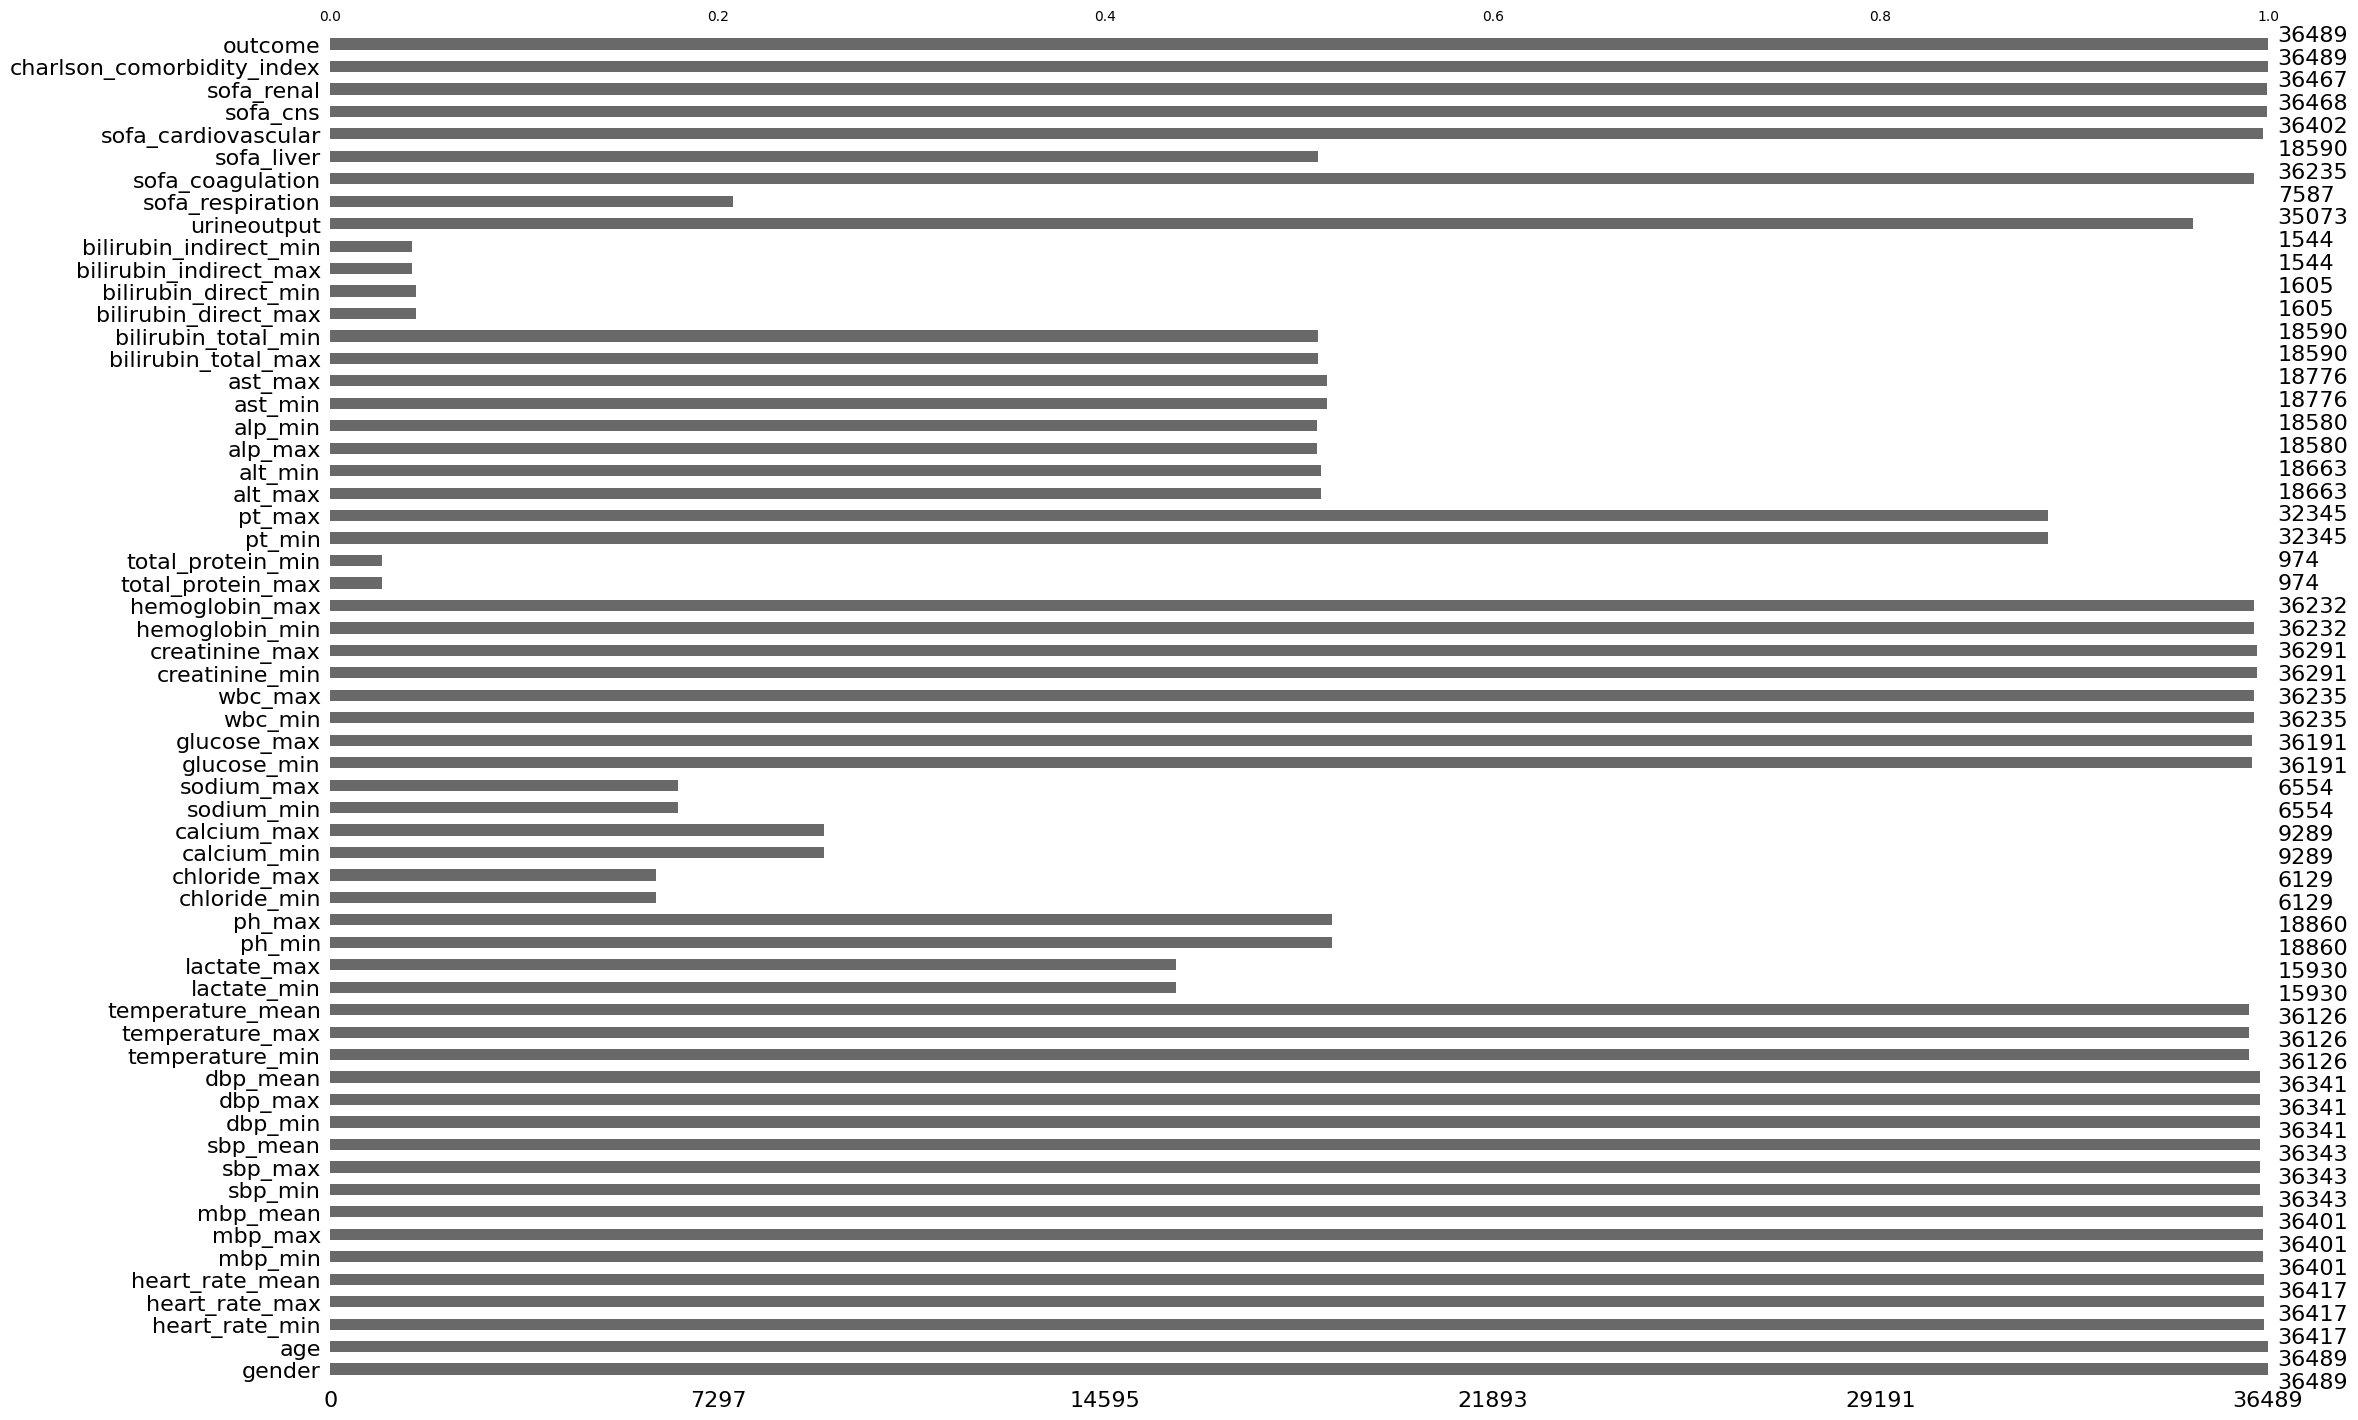

In [33]:
msno.bar(data)

In [39]:
data = shuffle(data)
ser = data.isnull().sum()/len(data)*100
ser = ser[(ser>= 60)]
data_new = data.drop(ser.index, axis=1)
print("we will delete {} feature because its missing percentage more than 70%,they are:".format(len(ser.index)))
for feature in ser.index:
    print(feature)
# data_new = data_new.fillna(method='ffill')
# data = data.dropna(axis=0,thresh=data.shape[1]-5)

we will delete 11 feature because its missing percentage more than 70%,they are:
chloride_min
chloride_max
sodium_min
sodium_max
total_protein_max
total_protein_min
bilirubin_direct_max
bilirubin_direct_min
bilirubin_indirect_max
bilirubin_indirect_min
sofa_respiration


In [40]:
data_new.head()

,gender,age,heart_rate_min,heart_rate_max,heart_rate_mean,mbp_min,mbp_max,mbp_mean,sbp_min,sbp_max,...,bilirubin_total_max,bilirubin_total_min,urineoutput,sofa_coagulation,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal,charlson_comorbidity_index,outcome
30164,1,71.049575,78.0,96.0,84.846154,83.0,121.0,106.307692,105.0,158.0,...,0.7,0.7,1450.0,0.0,0.0,0.0,1.0,1.0,7,False
3190,1,78.845136,54.0,74.0,62.360000,57.0,100.0,75.038462,96.0,148.0,...,NaN,NaN,980.0,0.0,NaN,1.0,1.0,0.0,6,False
2353,1,65.862033,63.0,99.0,80.642857,58.0,90.0,72.166667,88.0,152.0,...,NaN,NaN,1875.0,0.0,NaN,1.0,2.0,0.0,8,False
7727,1,28.250041,88.0,101.0,94.736842,96.0,134.0,117.687500,144.0,183.0,...,0.3,0.3,NaN,0.0,0.0,0.0,2.0,4.0,4,False
1107,1,61.837481,112.0,132.0,122.280000,76.0,98.0,85.043478,105.0,141.0,...,NaN,NaN,835.0,0.0,NaN,0.0,0.0,2.0,3,False


Deal with NA using KNN

In [41]:
X = data_new.iloc[:, :-1].values
y = data_new.iloc[:, -1].values
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

imputer = KNNImputer(n_neighbors=5, weights='distance', missing_values=np.nan)
imputer.fit(X)
# transform the dataset
Xtrans = imputer.transform(X)

In [42]:
print('Missing: %d' % sum(np.isnan(Xtrans).flatten()))

Missing: 0


Normalization and save


In [43]:
Xtrans = pd.DataFrame(Xtrans)
Xtrans = Xtrans.apply(lambda x : (x - np.mean(x))/np.std(x))
pd.DataFrame(data=np.hstack((Xtrans, y.reshape(-1, 1))), columns=data_new.keys()).to_csv(save_path/'Assignment_1_data_processed.csv', index=False)

# Feature Selection

In [3]:
# read the processed data
data = pd.read_csv(save_path/'Assignment_1_data_processed.csv')
data.head()

,gender,age,heart_rate_min,heart_rate_max,heart_rate_mean,mbp_min,mbp_max,mbp_mean,sbp_min,sbp_max,...,bilirubin_total_max,bilirubin_total_min,urineoutput,sofa_coagulation,sofa_liver,sofa_cardiovascular,sofa_cns,sofa_renal,charlson_comorbidity_index,outcome
0,0.914037,0.306146,0.469488,-0.343847,-0.000359,1.692150,0.665188,2.302081,0.632016,0.451583,...,-0.225535,-0.189862,-0.352975,-0.583736,-0.549446,-1.091077,0.080477,0.144678,0.398672,0.0
1,0.914037,0.770243,-1.124640,-1.408239,-1.408574,-0.257160,-0.235093,-0.359052,0.092542,0.013481,...,-0.248899,-0.231972,-0.727132,-0.583736,-0.549446,-0.062054,0.080477,-0.687804,0.066970,0.0
2,0.914037,-0.002687,-0.526842,-0.198703,-0.263594,-0.182187,-0.663798,-0.603453,-0.386990,0.188722,...,-0.242938,-0.209091,-0.014640,-0.583736,-0.549446,-0.062054,1.032366,-0.687804,0.730375,0.0
3,0.914037,-2.241860,1.133708,-0.101940,0.619055,2.666805,1.222505,3.270547,2.969733,1.546836,...,-0.356659,-0.334745,-0.583198,-0.583736,-0.549446,-1.091077,1.032366,2.642123,-0.596436,0.0
4,0.914037,-0.242282,2.727837,1.397885,2.343969,1.167336,-0.320834,0.492414,0.632016,-0.293189,...,1.079555,0.962111,-0.842564,-0.583736,1.130035,-1.091077,-0.871413,0.977159,-0.928139,0.0


Handing the imbalance data

In [5]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [6]:
y_train = pd.DataFrame(y_train)
y_train.value_counts()

outcome
0.0        28128
1.0         1063
dtype: int64

In [7]:
smote_os = SMOTE(random_state = 42) 
X_train, y_train = smote_os.fit_resample(X_train, y_train)#BorderlineSMOTEy_train.value_counts()

In [ ]:
y_train.value_counts()

outcome
0.0        28128
1.0        28128
dtype: int64

In [10]:
# genetic algorithm

estimator = DecisionTreeClassifier()
selectors = GeneticSelectionCV(estimator, cv=5, verbose=1, scoring="f1", n_population=30, crossover_proba=0.5,
  mutation_proba=0.2, n_generations=40, crossover_independent_proba=0.5,
  mutation_independent_proba=0.05, tournament_size=3, caching=True, max_features=20)
selectors = selectors.fit(X_train, y_train.to_numpy().ravel())
print('Features:', X.columns[selectors.support_])


Selecting features with genetic algorithm.
gen	nevals	avg                               	std                            	min                            	max                               
0  	30    	[  0.902115  11.066667   0.02007 ]	[ 0.072781  5.072365  0.005056]	[ 0.648504  2.        0.012299]	[  0.946352  19.         0.036817]
1  	19    	[  0.934534  13.333333   0.020765]	[ 0.013937  4.482063  0.005572]	[ 0.874145  2.        0.012796]	[  0.946352  19.         0.036817]
2  	16    	[  0.940674  12.         0.023352]	[ 0.004897  5.196152  0.006371]	[ 0.930002  2.        0.014997]	[  0.946352  18.         0.036817]
3  	18    	[  0.94083   10.1        0.024871]	[ 0.007374  5.957348  0.007029]	[ 0.914354  2.        0.016352]	[  0.949221  19.         0.036817]
4  	18    	[ 0.938889  9.466667  0.024857]   	[ 0.011605  5.339996  0.006363]	[ 0.896386  2.        0.014707]	[  0.949221  19.         0.036817]
5  	20    	[ 0.942355  8.566667  0.025458]   	[ 0.010017  4.402146  0.005345]	[ 0.90883

In [11]:
X.columns[selectors.support_]

Index(['heart_rate_mean', 'dbp_min', 'dbp_mean', 'lactate_max', 'calcium_min',
       'calcium_max', 'glucose_min', 'glucose_max', 'creatinine_max', 'pt_min',
       'alp_max', 'sofa_cns', 'charlson_comorbidity_index'],
      dtype='object')

In [12]:
# feature_selected = list(X.columns[selectors.support_])
feature_selected = ['heart_rate_mean', 'dbp_min', 'dbp_mean', 'lactate_max', 'calcium_min',
       'calcium_max', 'glucose_min', 'glucose_max', 'creatinine_max', 'pt_min',
       'alp_max', 'sofa_cns', 'charlson_comorbidity_index']
columns_selected = ['heart_rate_mean', 'dbp_min', 'dbp_mean', 'lactate_max', 'calcium_min',
       'calcium_max', 'glucose_min', 'glucose_max', 'creatinine_max', 'pt_min',
       'alp_max', 'sofa_cns', 'charlson_comorbidity_index','outcome']
print("{} features are selected".format(len(feature_selected)))


13 features are selected


save the data after feature selection

In [13]:
X_selected = data[feature_selected]
y = data.iloc[:, -1].values
pd.DataFrame(data=np.hstack((X_selected,y.reshape(-1,1))),columns= columns_selected).to_csv(save_path/'Assignment_1_data_processed_selected_1.csv',index=False)
X_selected.head()

,heart_rate_mean,dbp_min,dbp_mean,lactate_max,calcium_min,calcium_max,glucose_min,glucose_max,creatinine_max,pt_min,alp_max,sofa_cns,charlson_comorbidity_index
0,-0.000359,1.910511,2.113201,-0.456456,1.973595,1.232244,-0.669979,-0.568801,0.114229,-0.371307,0.105208,0.080477,0.398672
1,-1.408574,-0.792218,-0.842025,0.050261,0.334744,0.489539,-0.142186,-0.489006,-0.427916,-0.308085,-0.322579,0.080477,0.066970
2,-0.263594,-0.454377,-0.841024,-0.628583,0.122156,-0.591994,1.893586,0.308950,-0.482131,0.091370,-0.396721,1.032366,0.730375
3,0.619055,2.924035,3.307261,-0.469677,-1.674849,-1.873749,1.541724,1.505882,4.939327,-0.260669,1.886797,1.032366,-0.596436
4,2.343969,1.741590,0.950348,0.502885,0.446818,0.005605,0.963666,0.105028,0.276873,-0.071005,0.406492,-0.871413,-0.928139


# Predictive Model

In [3]:
# read the data and split the train and test data
data = pd.read_csv(save_path/'Assignment_1_data_processed_selected.csv')
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

Handing the imbalance data

In [4]:
y_train = pd.DataFrame(y_train)
y_train.value_counts()

outcome
0.0        28122
1.0         1069
dtype: int64

In [5]:
smote_os = SMOTE(random_state = 42) 
X_train, y_train = smote_os.fit_resample(X_train, y_train)#BorderlineSMOTE

In [6]:
y_train.value_counts()

outcome
0.0        28122
1.0        28122
dtype: int64

Logistc Regression

In [20]:
#Logistic Regression
p = {
    'C':list(np.linspace(0.05,1,19)),
    'solver':['liblinear','sag','newton-cg','lbfgs']}

model = LogisticRegression(penalty='l2',max_iter=10000)
GS = GridSearchCV(model,p,cv=5)
GS.fit(X_train,y_train.to_numpy().ravel())
#输出最优参数
GS.best_estimator_

LogisticRegression(C=0.05, max_iter=10000, solver='liblinear')

In [25]:
logistic_model = LogisticRegression(C=0.05, max_iter=10000, solver='liblinear')
# logistic_model = GS.best_estimator_

logistic_model.fit(X_train, y_train.to_numpy().ravel())
y_pred = logistic_model.predict(X_test)

accurate_lr = accuracy_score(y_test, y_pred)
precision_lr_weighted = precision_score(y_test, y_pred, average='weighted')
Recall_score_lr_weighted = recall_score(y_test, y_pred,average='weighted')
F1_score_lr_weighted = f1_score(y_test, y_pred,average='weighted')

precision_lr = precision_score(y_test, y_pred)
Recall_score_lr = recall_score(y_test, y_pred)
F1_score_lr = f1_score(y_test, y_pred)


fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred,drop_intermediate=False)
auc_lr = metrics.auc(fpr, tpr)

print('accuracy_weighted:',accurate_lr)
print('precision_weighted:',precision_lr_weighted)
print('recall score_weighted:',Recall_score_lr_weighted)
print('F1 score_weighted:',F1_score_lr_weighted )
print('\n')
print('precision:',precision_lr)
print('recall score:',Recall_score_lr)
print('F1 score:',F1_score_lr )
print('AUC:',auc_lr)

accuracy_weighted: 0.7728144697177309
precision_weighted: 0.952432522851983
recall score_weighted: 0.7728144697177309
F1 score_weighted: 0.843526236562939


precision: 0.09827586206896552
recall score: 0.6576923076923077
F1 score: 0.171
AUC: 0.7173798281854548


Text(50.722222222222214, 0.5, 'true')

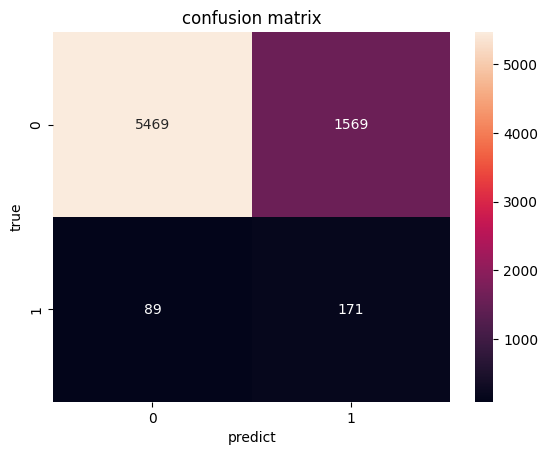

In [9]:
cm = confusion_matrix(y_test,y_pred,labels=[0,1])
annot = True #显示数字 ，fmt参数不使用科学计数法进行显示
ax = sn.heatmap(cm,annot=True,fmt='.20g')
ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y

Decision Tree

In [ ]:
# Decision Tree
p = {     'max_depth': np.arange(2,13),
          'min_impurity_decrease': np.linspace(0, 1, 100)
       }
        
model = DecisionTreeClassifier()
GS = GridSearchCV(model,p,cv=5)
GS.fit(X_train,y_train.to_numpy().ravel())
#输出最优参数
GS.best_estimator_

DecisionTreeClassifier(max_depth=12)

In [26]:
decision_tree_model = DecisionTreeClassifier(max_depth= 12)
# decision_tree_model = GS.best_estimator_

decision_tree_model.fit(X_train, y_train.to_numpy().ravel())
y_pred = decision_tree_model.predict(X_test)

accurate_dt = accuracy_score(y_test, y_pred)
precision_dt_weighted = precision_score(y_test, y_pred,average='weighted')
Recall_score_dt_weighted = recall_score(y_test, y_pred,average='weighted')
F1_score_dt_weighted = f1_score(y_test, y_pred,average='weighted')

precision_dt = precision_score(y_test, y_pred)
Recall_score_dt = recall_score(y_test, y_pred)
F1_score_dt = f1_score(y_test, y_pred)

fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred,drop_intermediate=False)
auc_dt = metrics.auc(fpr, tpr)

print('accuracy:',accurate_dt)
print('precision_weighted:',precision_dt_weighted)
print('recall score_weighted:',Recall_score_dt_weighted)
print('F1 score_weighted:',F1_score_dt_weighted)
print('\n')
print('accuracy:',accurate_dt)
print('precision:',precision_dt)
print('recall score:',Recall_score_dt)
print('F1 score:',F1_score_dt)

print('AUC:',auc_dt)

accuracy: 0.8957248561249658
precision_weighted: 0.9443059952981238
recall score_weighted: 0.8957248561249658
F1 score_weighted: 0.9174435536570458


accuracy: 0.8957248561249658
precision: 0.13215859030837004
recall score: 0.34615384615384615
F1 score: 0.1912858660998937
AUC: 0.6310905633156273


Text(50.722222222222214, 0.5, 'true')

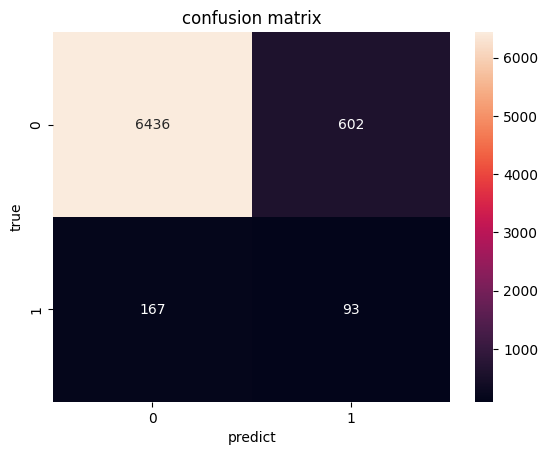

In [13]:
cm = confusion_matrix(y_test,y_pred,labels=[0,1])
annot = True #显示数字 ，fmt参数不使用科学计数法进行显示
ax = sn.heatmap(cm,annot=True,fmt='.20g')
ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y

Random Forest

In [8]:
# random forest
p = { 'n_estimators': [200,500], 
     'max_features':np.arange(5,13,2),
     }
                      
model = RandomForestClassifier( max_depth = 12)
GS = GridSearchCV(model,p,cv=5)
GS.fit(X_train,y_train.to_numpy().ravel())
#输出最优参数
GS.best_estimator_ 

RandomForestClassifier(max_depth=12, max_features=7, n_estimators=200)

In [10]:
# random forest
p = { 
    'max_depth':np.arange(2,13)
     }
                      
model = RandomForestClassifier( max_features=7,n_estimators=200)
GS = GridSearchCV(model,p,cv=5)
GS.fit(X_train,y_train.to_numpy().ravel())
#输出最优参数
GS.best_estimator_ 

RandomForestClassifier(max_depth=12, max_features=7, n_estimators=200)

In [27]:
#Random Forest
# random_forest_model = GS.best_estimator_
random_forest_model = RandomForestClassifier(max_depth=12, max_features=7, n_estimators=200)

random_forest_model.fit(X_train, y_train.to_numpy().ravel())
y_pred= random_forest_model.predict(X_test)

#evaluate
accurate_rf = accuracy_score(y_test, y_pred)
precision_rf_weighted = precision_score(y_test, y_pred,average = 'weighted')
Recall_score_rf_weighted = recall_score(y_test, y_pred,average = 'weighted')
F1_score_rf_weighted = f1_score(y_test, y_pred,average = 'weighted')

precision_rf = precision_score(y_test, y_pred)
Recall_score_rf = recall_score(y_test, y_pred)
F1_score_rf = f1_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred,drop_intermediate=False)
auc_rf = metrics.auc(fpr, tpr)


print('accuracy:',accurate_rf)
print('precision_weighted:',precision_rf_weighted)
print('recall score_weighted:',Recall_score_rf_weighted)
print('F1 score_weighted:',F1_score_rf_weighted)
print('\n')
print('accuracy:',accurate_rf)
print('precision:',precision_rf)
print('recall score:',Recall_score_rf)
print('F1 score:',F1_score_rf)

print('AUC:',auc_rf)

accuracy: 0.9106604549191559
precision_weighted: 0.9445277948532235
recall score_weighted: 0.9106604549191559
F1 score_weighted: 0.9260302808368098


accuracy: 0.9106604549191559
precision: 0.15
recall score: 0.3230769230769231
F1 score: 0.20487804878048782
AUC: 0.6277220364176885


Text(50.722222222222214, 0.5, 'true')

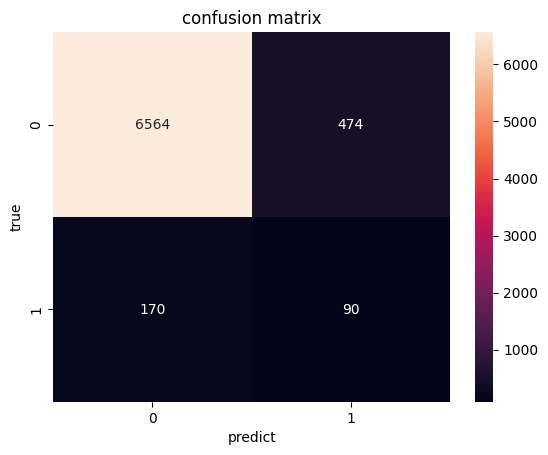

In [15]:
cm = confusion_matrix(y_test,y_pred,labels=[0,1])
annot = True #显示数字 ，fmt参数不使用科学计数法进行显示
ax = sn.heatmap(cm,annot=True,fmt='.20g')
ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y

SVM

In [30]:
p = {'C': [ 0.01,0.1, 1, 10,100]}
    
model = svm.SVC(kernel='rbf')
GS = GridSearchCV(model,p,cv=5)
GS.fit(X_train,y_train.to_numpy().ravel())
#输出最优参数
GS.best_estimator_

SVC(C=100)

In [28]:
#SVM model
svm_model = svm.SVC(kernel='rbf', C= 100)
# svm_model = GS.best_estimator_

svm_model.fit(X_train, y_train.to_numpy().ravel())
y_pred = svm_model.predict(X_test)

#evaluate
accurate_svm = accuracy_score(y_test, y_pred)
precision_svm_weighted = precision_score(y_test, y_pred,average='weighted')
Recall_score_svm_weighted = recall_score(y_test, y_pred,average='weighted')
F1_score_svm_weighted = f1_score(y_test, y_pred,average='weighted')

precision_svm = precision_score(y_test, y_pred)
Recall_score_svm = recall_score(y_test, y_pred)
F1_score_svm = f1_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred,drop_intermediate=False)
auc_svm = metrics.auc(fpr, tpr)

print('accuracy:',accurate_svm)
print('precision_weighted:',precision_svm_weighted)
print('recall score_weighted:',Recall_score_svm_weighted)
print('F1 score_weighted:',F1_score_svm_weighted)
print('AUC:',auc_svm)
print()
print('accuracy:',accurate_svm)
print('precision:',precision_svm)
print('recall score:',Recall_score_svm)
print('F1 score:',F1_score_svm)
print('AUC:',auc_svm)

accuracy: 0.8622910386407235
precision_weighted: 0.9363343608135126
recall score_weighted: 0.8622910386407235
F1 score_weighted: 0.8960884864005711
AUC: 0.5526389708614773

accuracy: 0.8622910386407235
precision: 0.06635622817229336
recall score: 0.21923076923076923
F1 score: 0.10187667560321716
AUC: 0.5526389708614773


Text(50.722222222222214, 0.5, 'true')

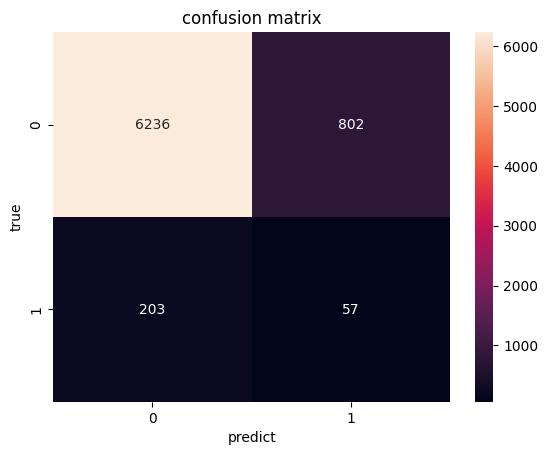

In [17]:
cm = confusion_matrix(y_test,y_pred,labels=[0,1])
annot = True #显示数字 ，fmt参数不使用科学计数法进行显示
ax = sn.heatmap(cm,annot=True,fmt='.20g')
ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y

In [31]:
scores_df = pd.DataFrame({
                          'accuracy':[accurate_lr,accurate_dt,accurate_rf,accurate_svm], 
                          'precision':[precision_lr,precision_dt,precision_rf,precision_svm], 
                          'precision_weighted':[precision_lr_weighted,precision_dt_weighted,precision_rf_weighted,precision_svm_weighted],
                          'Recall_score':[Recall_score_lr,Recall_score_dt,Recall_score_rf,Recall_score_svm],
                          'Recall_score_weighted':[Recall_score_lr_weighted,Recall_score_dt_weighted,Recall_score_rf_weighted,Recall_score_svm_weighted],
                          'F1_score':[F1_score_lr,F1_score_dt,F1_score_rf,F1_score_svm], 
                          'F1_score_weighted':[F1_score_lr_weighted,F1_score_dt_weighted,F1_score_rf_weighted,F1_score_svm_weighted],
                          'AUC': [auc_lr,auc_dt,auc_rf,auc_svm]
                          }, index = ['Logistic Regression','Decision Tree','Random Forest','SVM'],
)
scores_df

,accuracy,precision,precision_weighted,Recall_score,Recall_score_weighted,F1_score,F1_score_weighted,AUC
Logistic Regression,0.772814,0.098276,0.952433,0.657692,0.772814,0.171000,0.843526,0.717380
Decision Tree,0.895725,0.132159,0.944306,0.346154,0.895725,0.191286,0.917444,0.631091
Random Forest,0.910660,0.150000,0.944528,0.323077,0.910660,0.204878,0.926030,0.627722
SVM,0.862291,0.066356,0.936334,0.219231,0.862291,0.101877,0.896088,0.552639


# Improvement

AdaBoost

In [20]:
# from sklearn.ensemble import AdaBoostClassifier

# adaboost_model = AdaBoostClassifier(n_estimators=500)

# adaboost_model.fit(X_train, y_train.to_numpy().ravel())
# y_pred= adaboost_model.predict(X_test)

# #evaluate
# accurate_ada = accuracy_score(y_test, y_pred)
# precision_ada = precision_score(y_test, y_pred, average='weighted')
# Recall_score_ada = recall_score(y_test, y_pred, average='weighted')
# F1_score_ada = f1_score(y_test, y_pred, average='weighted')
# fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred,drop_intermediate=False)
# auc_ada = metrics.auc(fpr, tpr)


# print('accuracy:',accurate_ada)
# print('precision:',precision_ada)
# print('recall score:',Recall_score_ada)
# print('F1 score:',F1_score_ada)
# print('AUC:',auc_ada)

accuracy: 0.9371060564538229
precision: 0.939254653224831
recall score: 0.9371060564538229
F1 score: 0.938172071817476
AUC: 0.5599438214527728


Text(50.722222222222214, 0.5, 'true')

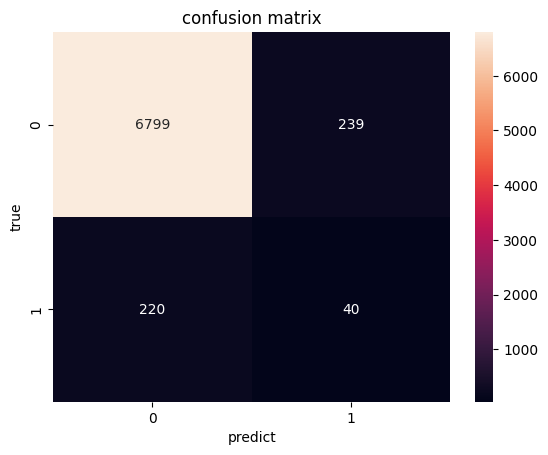

In [21]:
# cm = confusion_matrix(y_test,y_pred,labels=[0,1])
# annot = True #显示数字 ，fmt参数不使用科学计数法进行显示
# ax = sn.heatmap(cm,annot=True,fmt='.20g')
# ax.set_title('confusion matrix') #标题
# ax.set_xlabel('predict') #x轴
# ax.set_ylabel('true') #y

GradientBoosting

In [22]:
# from sklearn.ensemble import GradientBoostingClassifier

# GradientBoosting_model = GradientBoostingClassifier(n_estimators=500)

# GradientBoosting_model.fit(X_train, y_train.to_numpy().ravel())
# y_pred= GradientBoosting_model.predict(X_test)

# #evaluate
# accurate_gdbt = accuracy_score(y_test, y_pred)
# precision_gdbt = precision_score(y_test, y_pred, average='weighted')
# Recall_score_gdbt = recall_score(y_test, y_pred, average='weighted')
# F1_score_gdbt = f1_score(y_test, y_pred, average='weighted')
# fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred,drop_intermediate=False)
# auc_gdbt = metrics.auc(fpr, tpr)


# print('accuracy:',accurate_gdbt)
# print('precision:',precision_gdbt)
# print('recall score:',Recall_score_gdbt)
# print('F1 score:',F1_score_gdbt)
# print('AUC:',auc_gdbt)

accuracy: 0.9534118936694985
precision: 0.934026452592547
recall score: 0.9534118936694985
F1 score: 0.9431360490720965
AUC: 0.5109848733250268


Text(50.722222222222214, 0.5, 'true')

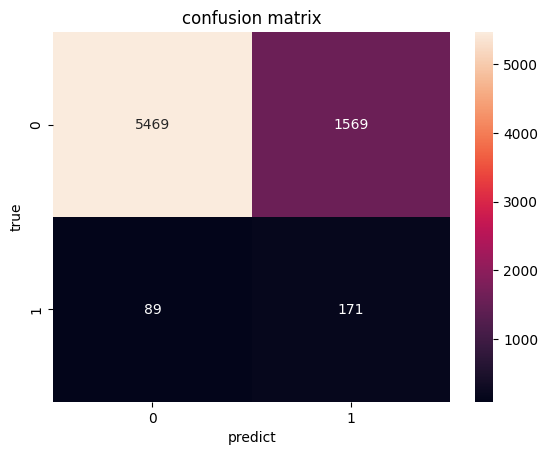

In [ ]:
# cm = confusion_matrix(y_test,y_pred,labels=[0,1])
# annot = True #显示数字 ，fmt参数不使用科学计数法进行显示
# ax = sn.heatmap(cm,annot=True,fmt='.20g')
# ax.set_title('confusion matrix') #标题
# ax.set_xlabel('predict') #x轴
# ax.set_ylabel('true') #y

In [ ]:
# scores_df = pd.DataFrame({
#                           'accuracy':[accurate_rf,accurate_ada,accurate_gdbt], 
#                           'precision':[precision_rf,precision_ada,precision_gdbt], 
#                           'Recall_score':[Recall_score_rf,Recall_score_ada,Recall_score_gdbt],
#                           'F1_score':[F1_score_rf,F1_score_ada,F1_score_gdbt],
#                           'AUC':[auc_rf,auc_ada,auc_gdbt]
#                             }, index = ['Randon Forest', 'AdaBoost','Gradient Boosting '],
# )
# scores_df

In [18]:
# cm = confusion_matrix(y_test,y_pred,labels=[0,1])
# #annot = True 显示数字 ，fmt参数不使用科学计数法进行显示
# ax = sn.heatmap(cm,annot=True,fmt='.20g')
# ax.set_title('confusion matrix') #标题
# ax.set_xlabel('predict') #x轴
# ax.set_ylabel('true') #y